In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Environment

In [ ]:

import os
import random
import json
from collections import defaultdict, Counter
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Vision
import torchvision.transforms as T
import torchvision.models as models

# NLP
import nltk
nltk.download("punkt")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import os
import glob


Using device: cuda


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Flickr8k Dataset

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip


In [ ]:
!unzip -q Flickr8k_Dataset.zip
!unzip -q Flickr8k_text.zip


In [ ]:
IMAGE_DIR = "/content/Flicker8k_Dataset"
CAPTION_FILE = "/content/Flickr8k.token.txt"


Dataset Devision

In [ ]:
import re
from collections import defaultdict

def load_captions(caption_file):
    image2caps = defaultdict(list)

    with open(caption_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Flickr8k.token.txt ： "<img>#<idx>\t<caption>"
            parts = line.split("\t")
            if len(parts) < 2:
                continue

            img_field, cap = parts[0], parts[1]

            img = img_field.split("#")[0]

            m = re.search(r"([0-9]+_[0-9a-fA-F]+\.jpg)", img)
            if m:
                img = m.group(1)
            else:
                continue

            image2caps[img].append(cap)

    return image2caps


Vocabulary

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<pad>",1:"<start>",2:"<end>",3:"<unk>"}
        self.stoi = {v:k for k,v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        return nltk.word_tokenize(text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [
            self.stoi.get(word, self.stoi["<unk>"])
            for word in self.tokenize(text)
        ]


In [ ]:
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab([c for caps in image2caps.values() for c in caps])
print("Vocab size:", len(vocab))


Vocab size: 3005


DataLoader

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, image_dir, image_list, image2caps, vocab, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.vocab = vocab

        self.samples = []
        for img in image_list:
            for cap in image2caps[img]:
                self.samples.append((img, cap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        image = self.transform(image)

        tokens = (
            [self.vocab.stoi["<start>"]] +
            self.vocab.numericalize(caption) +
            [self.vocab.stoi["<end>"]]
        )

        return image, torch.tensor(tokens)


In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = torch.stack([item[0] for item in batch])
        captions = pad_sequence(
            [item[1] for item in batch],
            batch_first=True,
            padding_value=self.pad_idx
        )
        return images, captions


In [ ]:
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

train_set = FlickrDataset(IMAGE_DIR, train_imgs, image2caps, vocab, transform)
val_set   = FlickrDataset(IMAGE_DIR, val_imgs,   image2caps, vocab, transform)
test_set  = FlickrDataset(IMAGE_DIR, test_imgs,  image2caps, vocab, transform)

pad_idx = vocab.stoi["<pad>"]

train_loader = DataLoader(
    train_set, batch_size=32, shuffle=True,
    collate_fn=MyCollate(pad_idx), num_workers=2
)


Model: ResNet-50 Encoder + LSTM Decoder

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1
        )
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.freeze_all()

    def freeze_all(self):
        for p in self.backbone.parameters():
            p.requires_grad = False

    def unfreeze_layer4(self):
        for name, p in self.backbone.named_parameters():
            if "layer4" in name:
                p.requires_grad = True

    def forward(self, images):
        x = self.backbone(images)
        x = x.squeeze(-1).squeeze(-1)
        return self.fc(x)


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions[:,:-1])
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens,_ = self.lstm(embeddings)
        return self.fc(hiddens)


    def sample(self, features, max_len=20):
        sampled = []
        inputs = features.unsqueeze(1)
        states = None
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            out = self.fc(hiddens.squeeze(1))
            pred = out.argmax(1)
            sampled.append(pred.item())
            inputs = self.embed(pred).unsqueeze(1)
        return sampled


In [ ]:
class CaptionModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        features = self.encoder(images)
        return self.decoder(features, captions)

    def caption_image(self, image, vocab):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))
            ids = self.decoder.sample(features)

        words = []
        for i in ids:
            word = vocab.itos[i]
            if word == "<end>":
                break
            words.append(word)
        return " ".join(words)


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

        self.train_losses = []
        self.val_losses = []

    def train_one_epoch(self, train_loader):
        self.model.train()
        total_loss = 0

        for images, captions in train_loader:
            images = images.to(self.device)
            captions = captions.to(self.device)

            outputs = self.model(images, captions)

            loss = self.criterion(
                outputs[:, :-1, :].reshape(-1, outputs.shape[2]),
                captions[:, 1:].reshape(-1)
            )

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate_one_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(self.device)
                captions = captions.to(self.device)

                outputs = self.model(images, captions)

                loss = self.criterion(
                    outputs[:, :-1, :].reshape(-1, outputs.shape[2]),
                    captions[:, 1:].reshape(-1)
                )

                total_loss += loss.item()

        return total_loss / len(val_loader)


Train: Fronze then Fine-tuning

In [ ]:
model = CaptionModel(
    embed_size=256,
    hidden_size=512,
    vocab_size=len(vocab)
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(
    list(model.encoder.fc.parameters()) + list(model.decoder.parameters()),
    lr=1e-3
)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


In [ ]:
val_loader = DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,              # 验证集别 shuffle
    collate_fn=MyCollate(pad_idx),
    num_workers=2
)


In [ ]:
EPOCHS = 4
trainer = Trainer(model, optimizer, criterion, device)

for epoch in range(EPOCHS):
    train_loss = trainer.train_one_epoch(train_loader)
    val_loss   = trainer.validate_one_epoch(val_loader)

    trainer.train_losses.append(train_loss)
    trainer.val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )


Epoch 01 | Train Loss: 4.1117 | Val Loss: 3.8301
Epoch 02 | Train Loss: 3.6228 | Val Loss: 3.6425
Epoch 03 | Train Loss: 3.3669 | Val Loss: 3.5586
Epoch 04 | Train Loss: 3.1625 | Val Loss: 3.5368


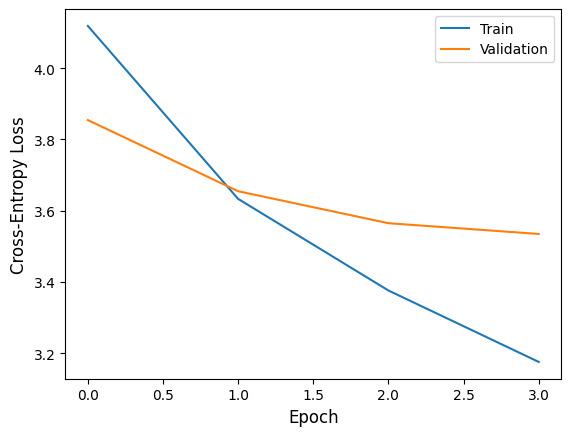

In [ ]:
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Cross-Entropy Loss", fontsize=12)
plt.plot(trainer.train_losses, label="Train")
plt.plot(trainer.val_losses, label="Validation")
plt.legend()


Plot Loss Curve

Img to Caption Example

In [ ]:
def decode_caption(caption_tensor, vocab):
    words = []
    for idx in caption_tensor.tolist():
        word = vocab.itos.get(idx, "<unk>")
        if word == "<end>":
            break
        if word not in ["<start>", "<pad>"]:
            words.append(word)
    return " ".join(words)


Text(0.5, -0.15, 'Ref: the man in the yellow jacket is\ncooking over an open fire as the\nlittle boy watches .\nGen: a child a and dog in field')

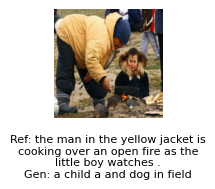

In [ ]:
import textwrap

plt.subplot(3, 3, i + 1)
plt.imshow(img)
plt.axis("off")

ref_wrapped = "\n".join(textwrap.wrap(ref_caption, 35))
gen_wrapped = "\n".join(textwrap.wrap(gen_caption, 35))

plt.text(
    0.5, -0.15,
    f"Ref: {ref_wrapped}\nGen: {gen_wrapped}",
    ha="center",
    va="top",
    transform=plt.gca().transAxes,
    fontsize=8
)

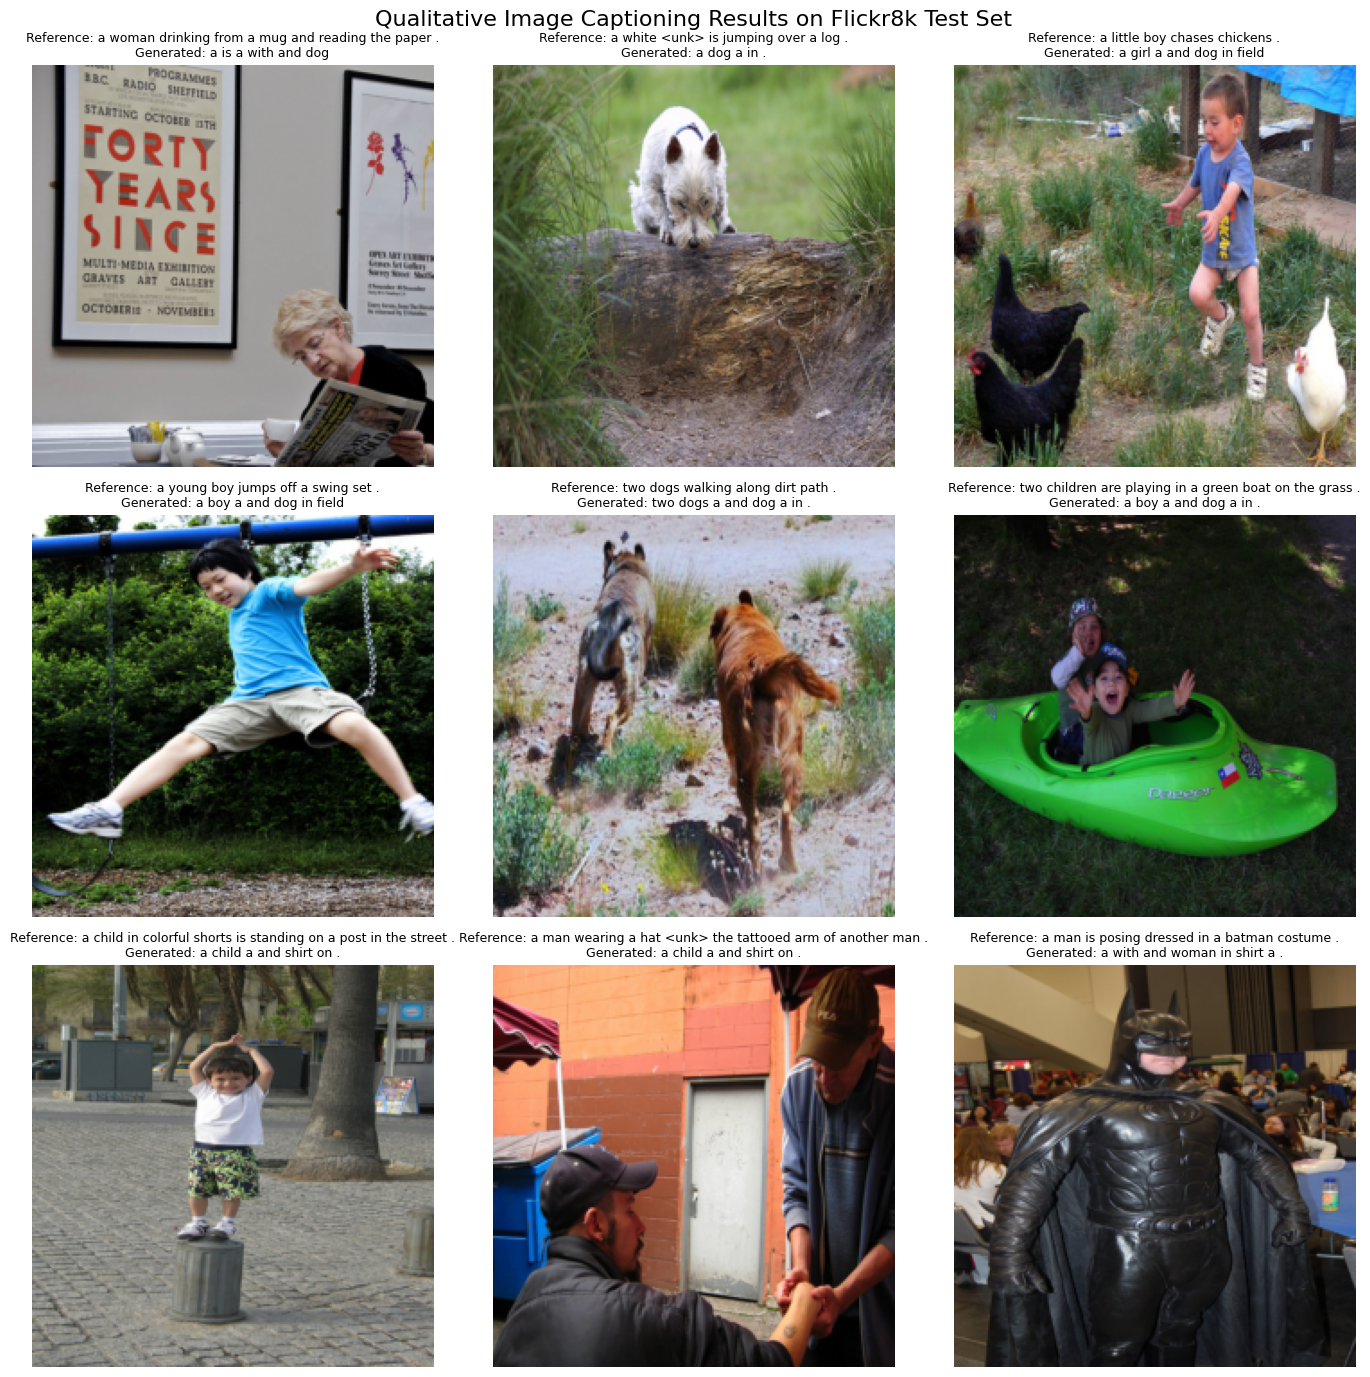

In [ ]:
import random
import matplotlib.pyplot as plt

model.eval()

num_samples = 9
indices = random.sample(range(len(test_set)), num_samples)

plt.figure(figsize=(14, 14))

for i, idx in enumerate(indices):
    image, ref_caption_tensor = test_set[idx]
    image = image.to(device)

    # generating caption
    gen_caption = model.caption_image(image, vocab)

    # reference caption（decoding）
    ref_caption = decode_caption(ref_caption_tensor, vocab)
    # （ImageNet）
    img = image.cpu().permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + \
          torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    plt.title(
        f"Reference: {ref_caption}\nGenerated: {gen_caption}",
        fontsize=9
    )

plt.suptitle("Qualitative Image Captioning Results on Flickr8k Test Set", fontsize=16)
plt.tight_layout()
plt.show()


Save Model to Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/flickr8k_cnn_lstm_04.pth"

torch.save({
    "encoder": model.encoder.state_dict(),
    "decoder": model.decoder.state_dict(),
    "vocab": vocab.stoi
}, SAVE_PATH)

print("Model saved to:", SAVE_PATH)


Model saved to: /content/drive/MyDrive/flickr8k_cnn_lstm_04.pth


Evaluation Index

BLEU

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu_weighted(preds, refs):
    hypotheses = []
    references = []

    for k in preds:
        hypotheses.append(preds[k][0].split())
        references.append([r.split() for r in refs[k]])

    smooth = SmoothingFunction().method4

    bleu = corpus_bleu(
        references,
        hypotheses,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=smooth
    )

    return bleu



In [ ]:
predictions = []
references  = []

for img_name in preds:
    predictions.append(preds[img_name][0])  # str
    references.append(refs[img_name])        # List[str]


In [ ]:
import evaluate

bleu = evaluate.load("bleu")

bleu_score = bleu.compute(
    predictions=predictions,
    references=references
)

print(f"BLEU score (weighted 1–4): {bleu_score['bleu']:.4f}")


BLEU score (weighted 1–4): 0.0000


CIDEr

In [ ]:
!pip install pycocoevalcap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 25.3 MB/s eta 0:00:00


In [ ]:
def compute_cider(preds, refs):
    cider = Cider()
    score, _ = cider.compute_score(refs, preds)
    return score


In [ ]:
cider_score = compute_cider(preds, refs)
print(f"CIDEr score: {cider_score:.4f}")

CIDEr score: 0.0984


BERTScore(F1)

In [ ]:
!pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
import evaluate
import numpy as np

bertscore = evaluate.load("bertscore")

bert_results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="en",
    model_type="roberta-large"
)

bert_f1 = float(np.mean(bert_results["f1"]))
print(f"BERTScore (F1): {bert_f1:.4f}")



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.8600


CLIPScore

In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mfi2i513
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mfi2i513
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=9dec15b8715ddbe904c11ec21b23614a119ade3a2eec0d662dc095b63d22ba33
  Stored in directory: /tmp/pip-ephem-wheel-cache-pq6yvf06/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
import clip

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def compute_clipscore(model, dataset, preds):
    scores = []

    for img_name in preds:
        image_path = os.path.join(dataset.image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        image = clip_preprocess(image).unsqueeze(0).to(device)

        text = clip.tokenize(preds[img_name]).to(device)

        with torch.no_grad():
            image_feat = clip_model.encode_image(image)
            text_feat = clip_model.encode_text(text)

            image_feat /= image_feat.norm(dim=-1, keepdim=True)
            text_feat /= text_feat.norm(dim=-1, keepdim=True)

            score = (image_feat * text_feat).sum().item()
            scores.append(score)

    return sum(scores) / len(scores)


100%|████████████████████████████████████████| 338M/338M [00:00<00:00, 407MiB/s]


In [ ]:
preds = {}
refs  = {}

model.eval()

for img_name in test_imgs:
    # 1. read img
    image_path = os.path.join(IMAGE_DIR, img_name)
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)

    # 2. generate caption
    gen_caption = model.caption_image(image, vocab)

    # 3. save preds
    preds[img_name] = [gen_caption]

    # 4. save refs（
    refs[img_name] = image2caps[img_name]


Generating Comparison Examples for Group

In [ ]:
# =========================================
# Rebuild image_to_captions (GT captions)
# =========================================

import pandas as pd
from collections import defaultdict

df_all = pd.read_csv("flickr8k_captions.csv")

if "image" in df_all.columns:
    image_col = "image"
elif "image_file" in df_all.columns:
    image_col = "image_file"
else:
    raise ValueError(f"Cannot find image column in csv. Columns are: {df_all.columns}")

all_images = df_all[image_col].unique()

np.random.seed(42)
np.random.shuffle(all_images)

train_images = all_images[:6000]
val_images   = all_images[6000:7000]
test_images  = all_images[7000:8000]

In [ ]:
# =========================================
# Rebuild image_to_captions (GT captions)
# =========================================

import pandas as pd
from collections import defaultdict

df_all = pd.read_csv("flickr8k_captions.csv")

if "image" in df_all.columns:
    image_col = "image"
elif "image_file" in df_all.columns:
    image_col = "image_file"
else:
    raise ValueError(f"Cannot find image column in csv. Columns are: {df_all.columns}")

all_images = df_all[image_col].unique()

np.random.seed(42)
np.random.shuffle(all_images)

train_images = all_images[:6000]
val_images   = all_images[6000:7000]
test_images  = all_images[7000:8000]

In [ ]:
import os
import textwrap
from PIL import Image, ImageDraw, ImageFont
import torch


In [121]:
# ===============================
# CONFIG (MATCH CLASSMATE)
# ===============================
SAVE_DIR = "/content/drive/MyDrive/eva_qualitative"
os.makedirs(SAVE_DIR, exist_ok=True)

IMAGE_DIR = "/content/Flicker8k_Dataset"

CANVAS_W = 400
CANVAS_H = 140

LEFT_W = 200
RIGHT_W = 200

FONT_SIZE = 50
LINE_SPACING = 10


In [120]:
def load_font(size):
    try:
        return ImageFont.truetype(
            "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
            size
        )
    except:
        return ImageFont.load_default()

font = load_font(FONT_SIZE)


In [122]:
def draw_caption(draw, text, x, y, max_chars):
    lines = textwrap.wrap(text, width=max_chars)
    cur_y = y
    for line in lines:
        draw.text((x, cur_y), line, fill=(0, 0, 0), font=font)
        cur_y += font.size + LINE_SPACING


In [123]:
# ===============================
# CREATE PNG (NO WHITESPACE)
# ===============================
def create_png(image, caption):
    canvas = Image.new("RGB", (CANVAS_W, CANVAS_H), (255, 255, 255))
    draw = ImageDraw.Draw(canvas)

    # ---- Image fills LEFT half ----
    image = image.resize((LEFT_W, CANVAS_H))
    canvas.paste(image, (0, 0))

    # ---- Caption fills RIGHT half ----
    draw_wrapped_text(
        draw,
        caption,
        x=LEFT_W + 12,
        y=20,
        max_chars=30
    )

    return canvas



In [138]:
model.eval()

for i in range(NUM_SAMPLES):
    img_name = val_images[i]
    img_path = os.path.join(IMAGE_DIR, img_name)

    # read image
    image = Image.open(img_path).convert("RGB")

    # ===== image -> Tensor =====
    image_tensor = transform(image).to(device)

    # ===== generating caption（关键修正）=====
    with torch.no_grad():
        caption = model.caption_image(image_tensor, vocab)

    # ===== vidualization =====
    canvas = create_eval_image(image, caption)

    # save
    save_path = os.path.join(SAVE_DIR, f"val_{i:02d}.png")
    canvas.save(save_path)

    print(f"✔ saved {save_path}")

print("✅ Qualitative evaluation images generated.")



✔ saved /content/drive/MyDrive/eva_qualitative/val_00.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_01.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_02.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_03.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_04.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_05.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_06.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_07.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_08.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_09.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_10.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_11.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_12.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_13.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_14.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_15.png
✔ saved /content/drive/MyDrive/eva_qualitative/val_16.png
✔ saved /conte